In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

# Reading the Zillow Data

### Create Python Package for Allowing Flexibility and Quick Access to Data

In [2]:
zillow_site = requests.get('https://www.zillow.com/research/data/')

In [3]:
zillow_site

<Response [200]>

In [4]:
zillow_site.text

'\n<!doctype html>\n<html class="no-js" lang="en-US" prefix="og: http://ogp.me/ns#">\n<head>\n<meta charset="utf-8">\n<meta http-equiv="x-ua-compatible" content="ie=edge"><script type="text/javascript">(window.NREUM||(NREUM={})).loader_config={xpid:"VwUDV19AAAcEVlBRBAQ="};window.NREUM||(NREUM={}),__nr_require=function(t,n,e){function r(e){if(!n[e]){var o=n[e]={exports:{}};t[e][0].call(o.exports,function(n){var o=t[e][1][n];return r(o||n)},o,o.exports)}return n[e].exports}if("function"==typeof __nr_require)return __nr_require;for(var o=0;o<e.length;o++)r(e[o]);return r}({1:[function(t,n,e){function r(t){try{s.console&&console.log(t)}catch(n){}}var o,i=t("ee"),a=t(15),s={};try{o=localStorage.getItem("__nr_flags").split(","),console&&"function"==typeof console.log&&(s.console=!0,o.indexOf("dev")!==-1&&(s.dev=!0),o.indexOf("nr_dev")!==-1&&(s.nrDev=!0))}catch(c){}s.nrDev&&i.on("internal-error",function(t){r(t.stack)}),s.dev&&i.on("fn-err",function(t,n,e){r(e.stack)}),s.dev&&(r("NR AGENT IN 

In [5]:
import pandas as pd

In [6]:
z_df = pd.read_csv("http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPrice_AllHomes.csv")

In [7]:
z_df.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05,...,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
0,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,NaN,...,3440.0,3405.0,3470.0,3402.5,3400.0,3495.0,3500.0,3402.5,3402.5,3395.0
1,60657,Chicago,IL,Chicago,Cook,2,NaN,NaN,NaN,NaN,...,2100.0,2155.0,2000.0,1850.0,1816.0,1800.0,1750.0,1795.0,1750.0,1895.0
2,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,NaN,...,3750.0,3800.0,3700.0,3600.0,3587.5,3698.5,3700.0,3700.0,3550.0,3500.0
3,75070,McKinney,TX,Dallas-Fort Worth,Collin,4,NaN,NaN,NaN,NaN,...,1895.0,1850.0,1850.0,1860.0,1850.0,1850.0,1850.0,1850.0,1850.0,1850.0
4,77494,Cinco Ranch,TX,Houston,Fort Bend,5,NaN,NaN,NaN,NaN,...,2000.0,2100.0,2100.0,2200.0,2260.0,2200.0,2200.0,2100.0,2100.0,2100.0


In [8]:
len(z_df)

3120

## Data Exploration - Looking at North Park Rent

In [9]:
North_Park = z_df[z_df['RegionName'] == 92104]

In [10]:
North_Park_melted = pd.melt(North_Park,value_name='RentalPrice',var_name='Date',id_vars=['RegionName','City','State','Metro','CountyName','SizeRank'])

In [11]:
North_Park_melted.head()

,RegionName,City,State,Metro,CountyName,SizeRank,Date,RentalPrice
0,92104,San Diego,CA,San Diego,San Diego,360,2010-02,NaN
1,92104,San Diego,CA,San Diego,San Diego,360,2010-03,NaN
2,92104,San Diego,CA,San Diego,San Diego,360,2010-04,NaN
3,92104,San Diego,CA,San Diego,San Diego,360,2010-05,NaN
4,92104,San Diego,CA,San Diego,San Diego,360,2010-06,NaN


In [12]:
North_Park_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 8 columns):
RegionName     98 non-null int64
City           98 non-null object
State          98 non-null object
Metro          98 non-null object
CountyName     98 non-null object
SizeRank       98 non-null int64
Date           98 non-null object
RentalPrice    75 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 6.2+ KB


In [13]:
North_Park_melted['Date'] = pd.to_datetime(North_Park_melted['Date'],format='%Y-%m')
North_Park_melted = North_Park_melted.dropna().set_index('Date')
North_Park_melted.head()

,RegionName,City,State,Metro,CountyName,SizeRank,RentalPrice
Date,,,,,,,
2012-01-01,92104,San Diego,CA,San Diego,San Diego,360,1250.0
2012-02-01,92104,San Diego,CA,San Diego,San Diego,360,1345.0
2012-03-01,92104,San Diego,CA,San Diego,San Diego,360,1200.0
2012-04-01,92104,San Diego,CA,San Diego,San Diego,360,1200.0
2012-05-01,92104,San Diego,CA,San Diego,San Diego,360,1100.0


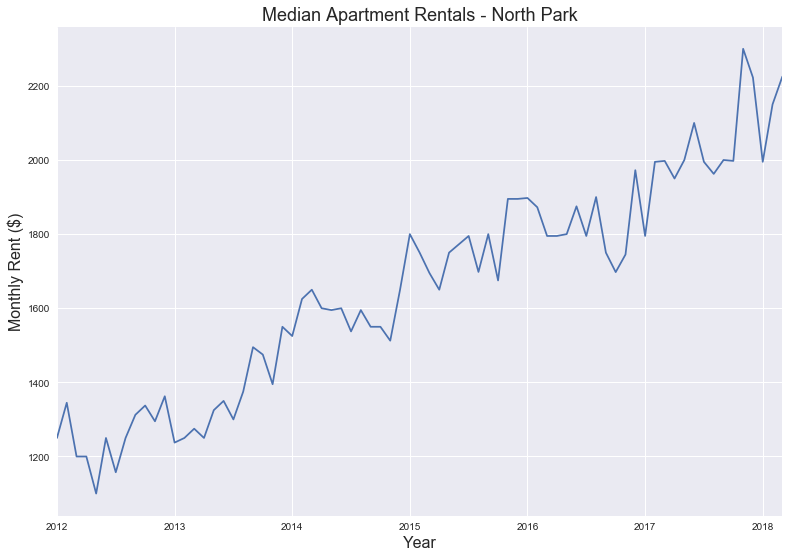

In [14]:
North_Park_melted['RentalPrice'].plot(figsize=(13,9))
plt.title('Median Apartment Rentals - North Park',fontsize=18)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Monthly Rent ($)',fontsize=16)
plt.show()

In [15]:
zhvi_all_homes = pd.read_csv("http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_AllHomes.csv")

In [16]:
zhvi_all_homes.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1084878,1094121,1098948,1107004,1123098,1137212,1141193,1139888,1139291,1139543
1,84654,60657,Chicago,IL,Chicago,Cook,2,159327.0,161854.0,163168.0,...,340877,343306,343628,343106,344351,346113,347148,346956,346246,345798
2,61637,10023,New York,NY,New York,New York,3,346658.0,351656.0,354675.0,...,1607956,1610929,1607674,1602395,1599531,1591998,1579702,1573290,1575598,1579506
3,84616,60614,Chicago,IL,Chicago,Cook,4,193062.0,197784.0,199184.0,...,418056,419501,418992,418986,421561,424279,424689,423415,423794,424873
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77490.0,77483.0,77538.0,...,119315,119559,119813,120238,120659,120877,120828,120619,120527,120540


In [17]:
len(zhvi_all_homes)

14769

In [18]:
zri_all_homes = pd.read_csv("http://files.zillowstatic.com/research/public/Zip/Zip_Zri_AllHomes.csv")

In [19]:
len(zri_all_homes)

15930

In [20]:
zri_all_homes.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-11,2010-12,2011-01,...,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,3676,3692,3711,3738,3732,3717,3685,3658,3632,3623
1,84654,60657,Chicago,IL,Chicago,Cook,2,1861.0,1863.0,1861.0,...,2085,2094,2100,2104,2107,2099,2086,2074,2070,2056
2,61637,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,...,4004,4063,4111,4162,4164,4125,4044,3988,3920,3893
3,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,4,1581.0,1583.0,1591.0,...,1938,1938,1938,1939,1940,1939,1936,1930,1924,1922
4,91982,77494,Katy,TX,Houston,Harris,5,2244.0,2247.0,2233.0,...,2237,2234,2234,2235,2234,2233,2238,2248,2261,2270


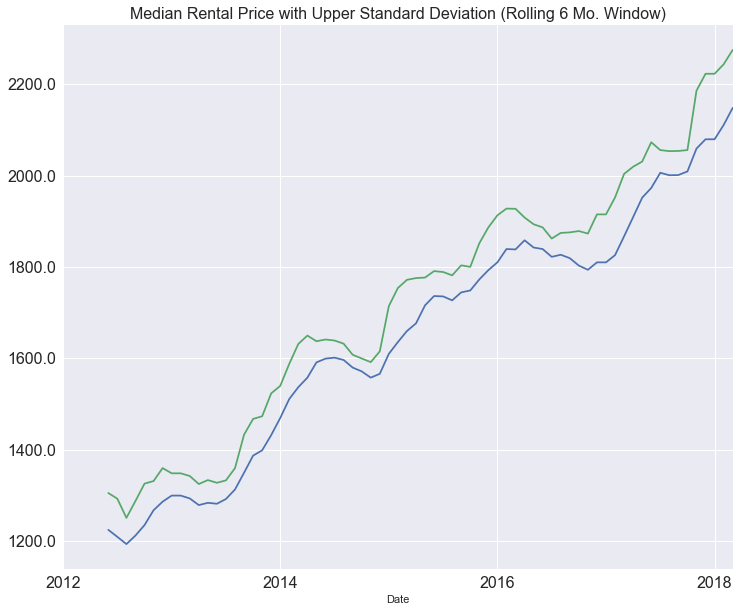

In [22]:
ax=North_Park_melted.rolling(6).mean()['RentalPrice'].plot(figsize=(12,10))
North_Park_melted.rolling(6).std().add(North_Park_melted.rolling(6).mean())['RentalPrice'].plot(ax=ax)
#North_Park_melted.rolling(3).mean().sub(North_Park_melted.rolling(3).std())['RentalPrice'].plot(ax=ax)
plt.title('Median Rental Price with Upper Standard Deviation (Rolling 6 Mo. Window)',fontsize=16)
ax.set_xticks(['2012','2014','2016','2018'])
ax.set_xticklabels(['2012','2014','2016','2018'],fontdict={'fontsize':16})
#ax.set_yticks('1200','1400','1600','1800','2000','2200'])
ax.set_yticklabels(ax.get_yticks(),fontdict={'fontsize':16})
plt.show()

- Need to put together a package that allows for selecting the Region Type (e.g. Zip Code, Neighborhood)
- Concatenate dataframes with different rooms, square footage as well. 
- Consider comparing Value vs. Rent, though unclear if it will translate meaningfully. 
- Need to import matplotlib.ticker and format to allow string on the y-axis ($ format)